# Sensitivity analysis on effect differences from FFT window size

This file generates and displays data for the within-study parameter sensitivity analysis.

In [1]:
# imports
import os
from functools import partial
from math import log
from pathlib import Path

from IPython.display import clear_output
import pandas as pd

import tools.plots as plts
from tools.index_sensitivity import IndexSensitivity
from tools.r_link import Rlink
from study_settings.big_vicky import BigVickySettings, BigVickyToolbox
from study_settings.carara import CararaSettings, CararaToolbox

/usr/lib/python3/dist-packages/paramiko/pkey.py:82: CryptographyDeprecationWarning: TripleDES has been moved to cryptography.hazmat.decrepit.ciphers.algorithms.TripleDES and will be removed from this module in 48.0.0.
  "cipher": algorithms.TripleDES,
/usr/lib/python3/dist-packages/paramiko/transport.py:237: CryptographyDeprecationWarning: Blowfish has been moved to cryptography.hazmat.decrepit.ciphers.algorithms.Blowfish and will be removed from this module in 45.0.0.
  "class": algorithms.Blowfish,
/usr/lib/python3/dist-packages/paramiko/transport.py:261: CryptographyDeprecationWarning: TripleDES has been moved to cryptography.hazmat.decrepit.ciphers.algorithms.TripleDES and will be removed from this module in 48.0.0.
  "class": algorithms.TripleDES,


In [2]:
# settings and r_link
r_link = Rlink()
r_link.capture_rpy2_output(errorwarn_callback=print)
r_link.load_src("tools/r_funcs.R")
indices_of_interest = ["ACI", "ADI", "AEI", "BIO"]
output_path = Path("./output")
# fft_window_sizes = [2**x for x in range(8, 13)] #6)]# + [22050, 48000]
plts.plt.rcParams.update({"font.size": 16})

In [3]:
def experiment(df:pd.DataFrame, group_to_process:tuple, toolbox:IndexSensitivity, r_link:Rlink, marine:bool, factors:list, cross_effect:str):
    '''
    Models and obtains conditional effects for every set of values in the dataframe. Sets are defined by grouping the "Index", "Filtered", and "Band" columns.
    This function is designed for use in this notebook and may not generalise well.

    df: dataframe of index values
    group_to_process: tuple with the multi-index of the group to model
    toolbox: an instance of the IndexSensitivity class, with settings relevant to the data and models
    r_link: an instance of the Rlink class
    marine: whether the data is from Big Vicky's (True) or Carara (False)
    factors: which columns to treat as factors
    cross_effect: which column is treated as the cross effect (along with Window) 

    returns: a matplotlib figure of the model, and a table with the posterior effects summary
    '''
    samp_to_s = partial(toolbox.samples_to_s, toolbox.settings.sample_rate)
    s_to_samp = partial(toolbox.s_to_samples, toolbox.settings.sample_rate)
    conditional_effects = {}
    grouped_data = df.groupby(['Index', 'Filtered', 'Band'], observed=False) 
    group = grouped_data.get_group(group_to_process).copy()
    index, filtered, band = group_to_process
    log_window = index != "AEI"
    if log_window:
        group["Window"] = group["Window"].apply(lambda x: log(x))

    if index not in conditional_effects:
        conditional_effects[index] = {True: {}, False: {}}

    txt = '_filtered' if filtered else ''
    trunc = group["Truncation"].unique().max()
    trunc = 0 if not trunc else trunc # rpy2 conversion issue
    flt = txt.replace('_', ' ')
    all_text = (index, flt, band, cross_effect)
    model, effects = toolbox.build_model(r_link, marine, all_text, group, factors, trunc)
    clear_output()
    print(model)
    filename = output_path / f"{cross_effect}_x_Window_conditional_effects_for_{index}_over{txt}_{band}_frequencies_Python"
    secax = ("Window duration (s)", (samp_to_s, s_to_samp))
    fig = plts.plot_conditional_effects(r_link,
                                    filename, 
                                    effects, 
                                    plot_points=True, 
                                    sec_ax=secax, 
                                    colors=toolbox.settings.colors, 
                                    unlog=log_window)
    conditional_effects[index][filtered][band] = effects
    posterior_ratios = r_link.r_src.get_posterior_ratios(model, num=toolbox.settings.num, den=toolbox.settings.den, cross=cross_effect)
    posterior_effects = r_link.r_src.get_posterior_ratio_difference(posterior_ratios)

    warnings = r_link.r_src.get_warnings()
    if warnings != r_link.null_value:
        print(warnings)

    return fig, posterior_effects

In [4]:
# from tools.populate_ipynb import CellAdder
# print(CellAdder.generate_index_definitions())

In [5]:
# index definitions
broadband_ACI_group = ('ACI', False, 'broadband')
broadband_ADI_group = ('ADI', False, 'broadband')
broadband_AEI_group = ('AEI', False, 'broadband')
broadband_BIO_group = ('BIO', False, 'broadband')
fish_extracted_ACI_group = ('ACI', False, 'fish')
fish_extracted_ADI_group = ('ADI', False, 'fish')
fish_extracted_AEI_group = ('AEI', False, 'fish')
fish_extracted_BIO_group = ('BIO', False, 'fish')
fish_filtered_ACI_group = ('ACI', True, 'fish')
fish_filtered_ADI_group = ('ADI', True, 'fish')
fish_filtered_AEI_group = ('AEI', True, 'fish')
fish_filtered_BIO_group = ('BIO', True, 'fish')
shrimp_extracted_ACI_group = ('ACI', False, 'shrimp')
shrimp_extracted_ADI_group = ('ADI', False, 'shrimp')
shrimp_extracted_AEI_group = ('AEI', False, 'shrimp')
shrimp_extracted_BIO_group = ('BIO', False, 'shrimp')
shrimp_filtered_ACI_group = ('ACI', True, 'shrimp')
shrimp_filtered_ADI_group = ('ADI', True, 'shrimp')
shrimp_filtered_AEI_group = ('AEI', True, 'shrimp')
shrimp_filtered_BIO_group = ('BIO', True, 'shrimp')

## Carara

In [6]:
# settings and frequency bands
carara_settings = CararaSettings
carara_settings.data_location = os.path.expanduser(carara_settings.data_location)
test_bands = [("broadband", (0, carara_settings.max_freq), False)]
fft_window_sizes = [2**x for x in range(8, 15)] + [22050]


In [7]:
carara_toolbox = CararaToolbox(carara_settings, fft_window_sizes, test_bands, indices_of_interest)

In [8]:
carara_index_values = carara_toolbox.get_index_values(output_file="output/terrestrial_index_values")

In [9]:
carara_df = carara_toolbox.create_dataframe(carara_index_values, output_path="output/terrestrial_dataframe.pkl")

### Carara - broadband ACI


In [10]:
carara_broadband_ACI_fig, carara_broadband_ACI_ratio_summary = experiment(carara_df,
          broadband_ACI_group,
          carara_toolbox,
          r_link,
          marine=False,
          factors=['Site', 'Day'],
          cross_effect='Site')


 Family: gamma 
  Links: mu = log; shape = identity 
Formula: Value ~ (Site * Window) + (1 | Day) 
   Data: data (Number of observations: 2288) 
  Draws: 5 chains, each with iter = 10000; warmup = 5000; thin = 1;
         total post-warmup draws = 25000

Multilevel Hyperparameters:
~Day (Number of levels: 5) 
              Estimate Est.Error l-95% CI u-95% CI Rhat Bulk_ESS Tail_ESS
sd(Intercept)     0.64      0.48     0.21     1.72 1.31       12       11

Regression Coefficients:
              Estimate Est.Error l-95% CI u-95% CI Rhat Bulk_ESS Tail_ESS
Intercept        -1.05      0.29    -1.57    -0.53 1.25       14       19
SiteIR            0.12      0.02     0.09     0.16 1.17     9127     8497
Window            1.03      0.00     1.03     1.03 1.06       55     7635
SiteIR:Window    -0.02      0.00    -0.02    -0.01 1.19    10312     8533

Further Distributional Parameters:
      Estimate Est.Error l-95% CI u-95% CI Rhat Bulk_ESS Tail_ESS
shape   181.46      4.91   171.57   191.72 

In [11]:
print(carara_broadband_ACI_ratio_summary)


# A tibble: 1 × 2
   mean      sd
  <dbl>   <dbl>
1  1.08 0.00932



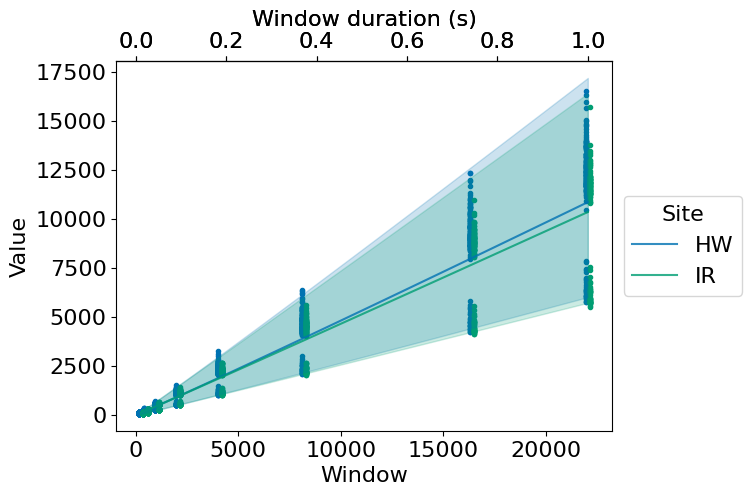

In [12]:
carara_broadband_ACI_fig


### Carara - broadband ADI


In [13]:
carara_broadband_ADI_fig, carara_broadband_ADI_ratio_summary = experiment(carara_df,
          broadband_ADI_group,
          carara_toolbox,
          r_link,
          marine=False,
          factors=['Site', 'Day'],
          cross_effect='Site')


 Family: gamma 
  Links: mu = log; shape = identity 
Formula: Value ~ (Site * Window) + (1 | Day) 
   Data: data (Number of observations: 2288) 
  Draws: 5 chains, each with iter = 10000; warmup = 5000; thin = 1;
         total post-warmup draws = 25000

Multilevel Hyperparameters:
~Day (Number of levels: 5) 
              Estimate Est.Error l-95% CI u-95% CI Rhat Bulk_ESS Tail_ESS
sd(Intercept)     0.07      0.05     0.03     0.22 1.01      825      239

Regression Coefficients:
              Estimate Est.Error l-95% CI u-95% CI Rhat Bulk_ESS Tail_ESS
Intercept         1.25      0.06     1.14     1.37 1.01      742      241
SiteIR            0.02      0.06    -0.10     0.13 1.00    11131    12549
Window           -0.03      0.00    -0.04    -0.02 1.00    13607    14627
SiteIR:Window     0.01      0.01    -0.01     0.02 1.00    11104    13151

Further Distributional Parameters:
      Estimate Est.Error l-95% CI u-95% CI Rhat Bulk_ESS Tail_ESS
shape    15.07      0.44    14.20    15.96 

In [14]:
print(carara_broadband_ADI_ratio_summary)


# A tibble: 1 × 2
   mean     sd
  <dbl>  <dbl>
1  1.04 0.0267



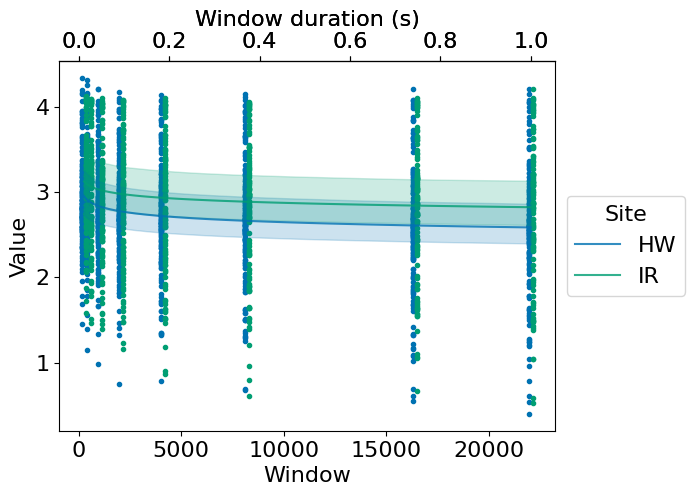

In [15]:
carara_broadband_ADI_fig


### Carara - broadband AEI


In [16]:
carara_broadband_AEI_fig, carara_broadband_AEI_ratio_summary = experiment(carara_df,
          broadband_AEI_group,
          carara_toolbox,
          r_link,
          marine=False,
          factors=['Site', 'Day'],
          cross_effect='Site')


 Family: beta 
  Links: mu = logit; phi = identity 
Formula: Value ~ (Site * Window) + (1 | Day) 
   Data: data (Number of observations: 2288) 
  Draws: 5 chains, each with iter = 10000; warmup = 5000; thin = 1;
         total post-warmup draws = 25000

Multilevel Hyperparameters:
~Day (Number of levels: 5) 
              Estimate Est.Error l-95% CI u-95% CI Rhat Bulk_ESS Tail_ESS
sd(Intercept)     0.18      0.12     0.07     0.48 1.01      325      492

Regression Coefficients:
              Estimate Est.Error l-95% CI u-95% CI Rhat Bulk_ESS Tail_ESS
Intercept         1.70      0.10     1.51     1.86 1.03      238      495
SiteIR           -0.24      0.04    -0.32    -0.16 1.00     3095     5899
Window            0.00      0.00     0.00     0.00 1.00    14137    17702
SiteIR:Window    -0.00      0.00    -0.00     0.00 1.00     8145    14860

Further Distributional Parameters:
    Estimate Est.Error l-95% CI u-95% CI Rhat Bulk_ESS Tail_ESS
phi    14.07      0.41    13.27    14.89 1.00 

In [17]:
print(carara_broadband_AEI_ratio_summary)


# A tibble: 1 × 2
   mean      sd
  <dbl>   <dbl>
1  1.01 0.00784



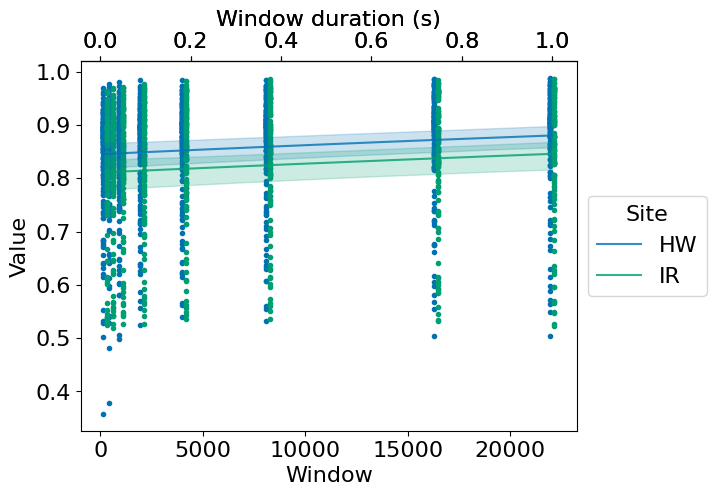

In [18]:
carara_broadband_AEI_fig


### Carara - broadband BIO


In [19]:
carara_broadband_BIO_fig, carara_broadband_BIO_ratio_summary = experiment(carara_df,
          broadband_BIO_group,
          carara_toolbox,
          r_link,
          marine=False,
          factors=['Site', 'Day'],
          cross_effect='Site')


 Family: gamma 
  Links: mu = log; shape = identity 
Formula: Value ~ (Site * Window) + (1 | Day) 
   Data: data (Number of observations: 2288) 
  Draws: 5 chains, each with iter = 10000; warmup = 5000; thin = 1;
         total post-warmup draws = 25000

Multilevel Hyperparameters:
~Day (Number of levels: 5) 
              Estimate Est.Error l-95% CI u-95% CI Rhat Bulk_ESS Tail_ESS
sd(Intercept)     0.94      0.44     0.43     2.23 1.01     1123      384

Regression Coefficients:
              Estimate Est.Error l-95% CI u-95% CI Rhat Bulk_ESS Tail_ESS
Intercept        -8.19      0.45    -9.09    -7.28 1.00     1607      405
SiteIR           -0.30      0.08    -0.45    -0.15 1.00    10045    12568
Window            2.03      0.01     2.02     2.04 1.00     8807    14455
SiteIR:Window     0.00      0.01    -0.01     0.02 1.00     9974    12450

Further Distributional Parameters:
      Estimate Est.Error l-95% CI u-95% CI Rhat Bulk_ESS Tail_ESS
shape     8.06      0.23     7.61     8.52 

In [20]:
print(carara_broadband_BIO_ratio_summary)


# A tibble: 1 × 2
   mean     sd
  <dbl>  <dbl>
1  1.04 0.0302



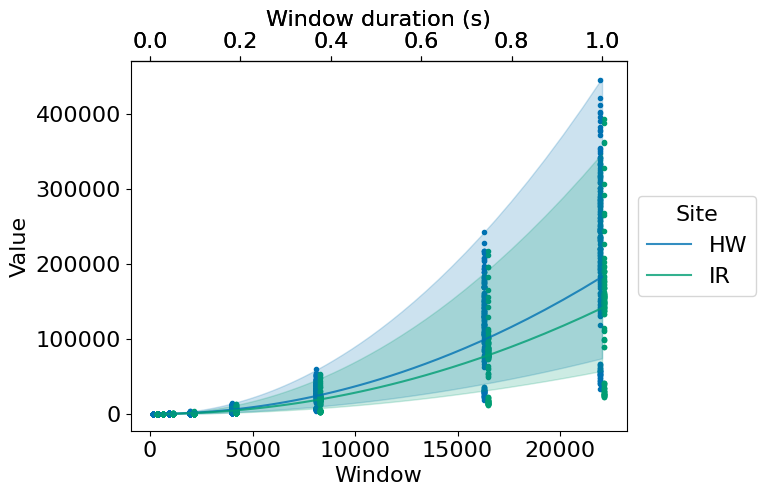

In [21]:
carara_broadband_BIO_fig


## Big Vicky

In [22]:
# settings and frequency bands
vicky_settings = BigVickySettings
vicky_settings.data_location = os.path.expanduser(vicky_settings.data_location)
test_bands = [("broadband", (100, vicky_settings.sample_rate), False),
              ("shrimp", vicky_settings.shrimp_frequencies, False),
              ("shrimp", vicky_settings.shrimp_frequencies, True),
              ("fish", vicky_settings.fish_frequencies, False),
              ("fish", vicky_settings.fish_frequencies, True)]

fft_window_sizes = [2**x for x in range(8, 16)] + [48000]

In [23]:
vicky_toolbox = BigVickyToolbox(vicky_settings, fft_window_sizes, test_bands, indices_of_interest)

In [24]:
vicky_index_values = vicky_toolbox.get_index_values(output_file="output/vicky_index_values.pkl")

In [25]:
vicky_df = vicky_toolbox.create_dataframe(vicky_index_values, output_path="output/vicky_dataframe.pkl")

### Big Vicky - broadband ACI


In [26]:
vicky_extracted_broadband_ACI_fig, vicky_extracted_broadband_ACI_ratio_summary = experiment(vicky_df,
          broadband_ACI_group,
          vicky_toolbox,
          r_link,
          marine=True,
          factors=['Hour', 'Site'],
          cross_effect='Hour')


 Family: gamma 
  Links: mu = log; shape = identity 
Formula: Value ~ (Hour * Window) + (1 | Site) 
   Data: data (Number of observations: 4977) 
  Draws: 5 chains, each with iter = 10000; warmup = 5000; thin = 1;
         total post-warmup draws = 25000

Multilevel Hyperparameters:
~Site (Number of levels: 25) 
              Estimate Est.Error l-95% CI u-95% CI Rhat Bulk_ESS Tail_ESS
sd(Intercept)     0.06      0.01     0.05     0.08 1.00     1764     3246

Regression Coefficients:
              Estimate Est.Error l-95% CI u-95% CI Rhat Bulk_ESS Tail_ESS
Intercept         0.34      0.01     0.32     0.37 1.00     1589     2514
Hour12           -0.09      0.01    -0.11    -0.08 1.00     6385     8231
Window            0.92      0.00     0.92     0.92 1.00     9360    13318
Hour12:Window     0.02      0.00     0.02     0.02 1.00     6428     8509

Further Distributional Parameters:
      Estimate Est.Error l-95% CI u-95% CI Rhat Bulk_ESS Tail_ESS
shape   406.99      8.26   390.69   423.

In [27]:
print(vicky_extracted_broadband_ACI_ratio_summary)


# A tibble: 1 × 2
   mean      sd
  <dbl>   <dbl>
1  1.10 0.00466



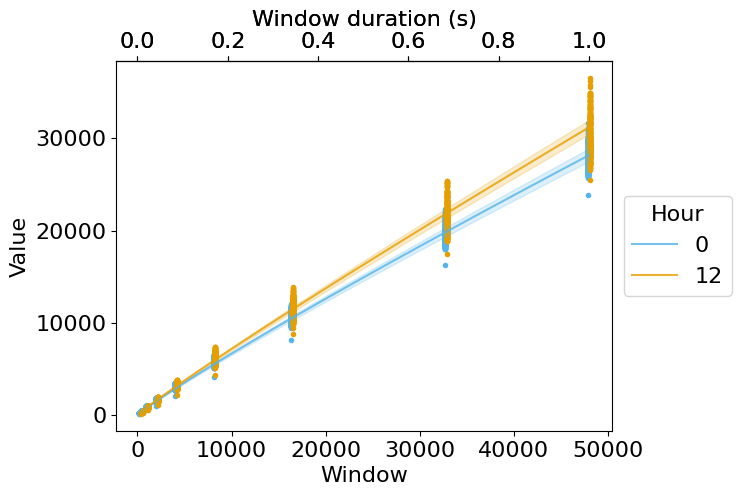

In [28]:
vicky_extracted_broadband_ACI_fig


### Big Vicky - extracted fish ACI


In [29]:
vicky_extracted_fish_ACI_fig, vicky_extracted_fish_ACI_ratio_summary = experiment(vicky_df,
          fish_extracted_ACI_group,
          vicky_toolbox,
          r_link,
          marine=True,
          factors=['Hour', 'Site'],
          cross_effect='Hour')


 Family: gamma 
  Links: mu = log; shape = identity 
Formula: Value ~ (Hour * Window) + (1 | Site) 
   Data: data (Number of observations: 4977) 
  Draws: 5 chains, each with iter = 10000; warmup = 5000; thin = 1;
         total post-warmup draws = 25000

Multilevel Hyperparameters:
~Site (Number of levels: 25) 
              Estimate Est.Error l-95% CI u-95% CI Rhat Bulk_ESS Tail_ESS
sd(Intercept)     0.05      0.01     0.03     0.06 1.00     2792     4198

Regression Coefficients:
              Estimate Est.Error l-95% CI u-95% CI Rhat Bulk_ESS Tail_ESS
Intercept        -3.64      0.01    -3.67    -3.62 1.00     2832     4951
Hour12           -0.16      0.01    -0.19    -0.14 1.00     8029    11189
Window            0.97      0.00     0.97     0.97 1.00    10965    15705
Hour12:Window     0.02      0.00     0.01     0.02 1.00     8002    11396

Further Distributional Parameters:
      Estimate Est.Error l-95% CI u-95% CI Rhat Bulk_ESS Tail_ESS
shape   141.26      2.88   135.66   147.

In [30]:
print(vicky_extracted_fish_ACI_ratio_summary)


# A tibble: 1 × 2
   mean      sd
  <dbl>   <dbl>
1  1.09 0.00804



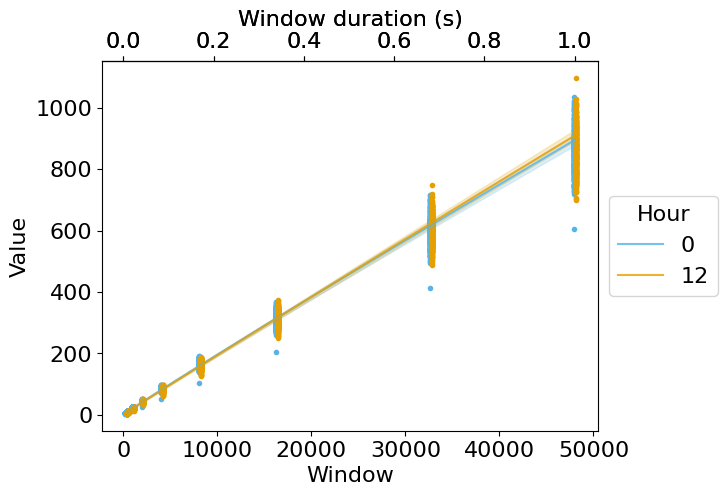

In [31]:
vicky_extracted_fish_ACI_fig


### Big Vicky - extracted shrimp ACI


In [32]:
vicky_extracted_shrimp_ACI_fig, vicky_extracted_shrimp_ACI_ratio_summary = experiment(vicky_df,
          shrimp_extracted_ACI_group,
          vicky_toolbox,
          r_link,
          marine=True,
          factors=['Hour', 'Site'],
          cross_effect='Hour')


 Family: gamma 
  Links: mu = log; shape = identity 
Formula: Value ~ (Hour * Window) + (1 | Site) 
   Data: data (Number of observations: 4977) 
  Draws: 5 chains, each with iter = 10000; warmup = 5000; thin = 1;
         total post-warmup draws = 25000

Multilevel Hyperparameters:
~Site (Number of levels: 25) 
              Estimate Est.Error l-95% CI u-95% CI Rhat Bulk_ESS Tail_ESS
sd(Intercept)     0.04      0.01     0.03     0.06 1.00     2058     4243

Regression Coefficients:
              Estimate Est.Error l-95% CI u-95% CI Rhat Bulk_ESS Tail_ESS
Intercept        -1.67      0.01    -1.69    -1.65 1.00     2172     3921
Hour12           -0.14      0.01    -0.16    -0.13 1.00     6752     9202
Window            0.92      0.00     0.92     0.92 1.00    10150    14104
Hour12:Window     0.03      0.00     0.02     0.03 1.00     6762     9076

Further Distributional Parameters:
      Estimate Est.Error l-95% CI u-95% CI Rhat Bulk_ESS Tail_ESS
shape   281.55      5.68   270.55   292.

In [33]:
print(vicky_extracted_shrimp_ACI_ratio_summary)


# A tibble: 1 × 2
   mean      sd
  <dbl>   <dbl>
1  1.14 0.00603



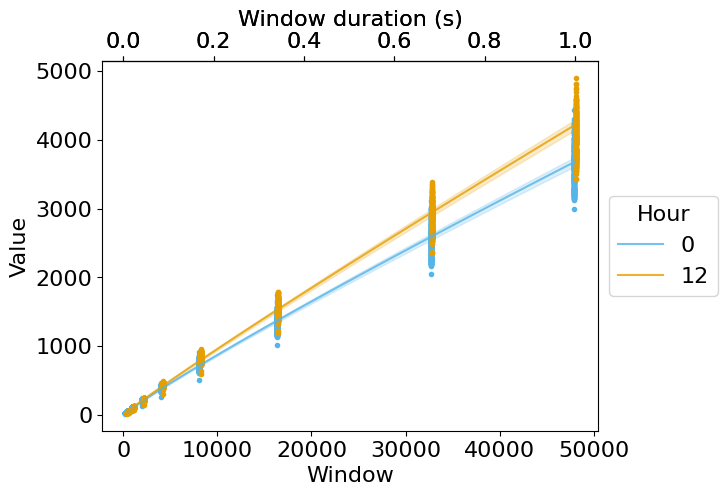

In [34]:
vicky_extracted_shrimp_ACI_fig


### Big Vicky - filtered fish ACI


In [35]:
vicky_filtered_fish_ACI_fig, vicky_filtered_fish_ACI_ratio_summary = experiment(vicky_df,
          fish_filtered_ACI_group,
          vicky_toolbox,
          r_link,
          marine=True,
          factors=['Hour', 'Site'],
          cross_effect='Hour')


 Family: gamma 
  Links: mu = log; shape = identity 
Formula: Value ~ (Hour * Window) + (1 | Site) 
   Data: data (Number of observations: 4977) 
  Draws: 5 chains, each with iter = 10000; warmup = 5000; thin = 1;
         total post-warmup draws = 25000

Multilevel Hyperparameters:
~Site (Number of levels: 25) 
              Estimate Est.Error l-95% CI u-95% CI Rhat Bulk_ESS Tail_ESS
sd(Intercept)     0.01      0.00     0.01     0.01 1.00     2963     3963

Regression Coefficients:
              Estimate Est.Error l-95% CI u-95% CI Rhat Bulk_ESS Tail_ESS
Intercept        -0.50      0.00    -0.51    -0.50 1.00     4982     9180
Hour12           -0.01      0.00    -0.01     0.00 1.00    20349    17239
Window            0.99      0.00     0.99     0.99 1.00    22677    18751
Hour12:Window     0.00      0.00     0.00     0.00 1.00    20360    16871

Further Distributional Parameters:
      Estimate Est.Error l-95% CI u-95% CI Rhat Bulk_ESS Tail_ESS
shape  2250.49     44.97  2163.04  2339.

In [36]:
print(vicky_filtered_fish_ACI_ratio_summary)


# A tibble: 1 × 2
   mean      sd
  <dbl>   <dbl>
1  1.01 0.00183



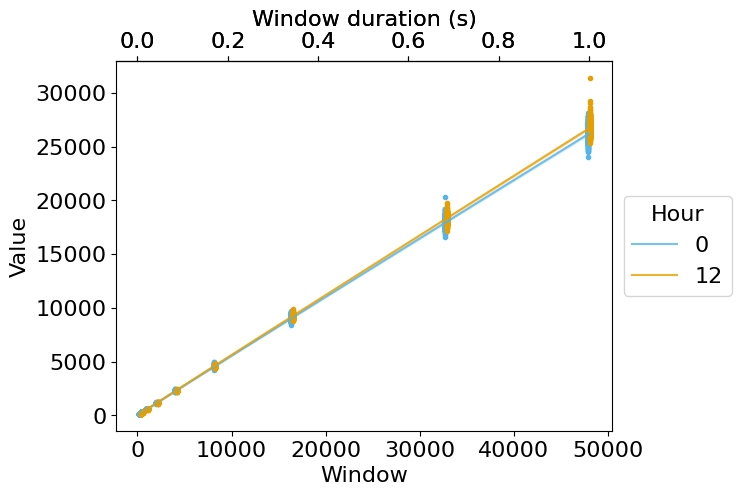

In [37]:
vicky_filtered_fish_ACI_fig


### Big Vicky - filtered shrimp ACI


In [38]:
vicky_filtered_shrimp_ACI_fig, vicky_filtered_shrimp_ACI_ratio_summary = experiment(vicky_df,
          shrimp_filtered_ACI_group,
          vicky_toolbox,
          r_link,
          marine=True,
          factors=['Hour', 'Site'],
          cross_effect='Hour')


 Family: gamma 
  Links: mu = log; shape = identity 
Formula: Value ~ (Hour * Window) + (1 | Site) 
   Data: data (Number of observations: 4977) 
  Draws: 5 chains, each with iter = 10000; warmup = 5000; thin = 1;
         total post-warmup draws = 25000

Multilevel Hyperparameters:
~Site (Number of levels: 25) 
              Estimate Est.Error l-95% CI u-95% CI Rhat Bulk_ESS Tail_ESS
sd(Intercept)     0.02      0.00     0.01     0.03 1.00     1673     2372

Regression Coefficients:
              Estimate Est.Error l-95% CI u-95% CI Rhat Bulk_ESS Tail_ESS
Intercept        -0.27      0.00    -0.27    -0.26 1.00     2183     3795
Hour12           -0.04      0.00    -0.05    -0.04 1.00    10509    13088
Window            0.97      0.00     0.97     0.97 1.00    14901    16985
Hour12:Window     0.01      0.00     0.01     0.01 1.00    10753    13459

Further Distributional Parameters:
      Estimate Est.Error l-95% CI u-95% CI Rhat Bulk_ESS Tail_ESS
shape  1484.50     29.85  1426.45  1543.

In [39]:
print(vicky_filtered_shrimp_ACI_ratio_summary)


# A tibble: 1 × 2
   mean      sd
  <dbl>   <dbl>
1  1.05 0.00234



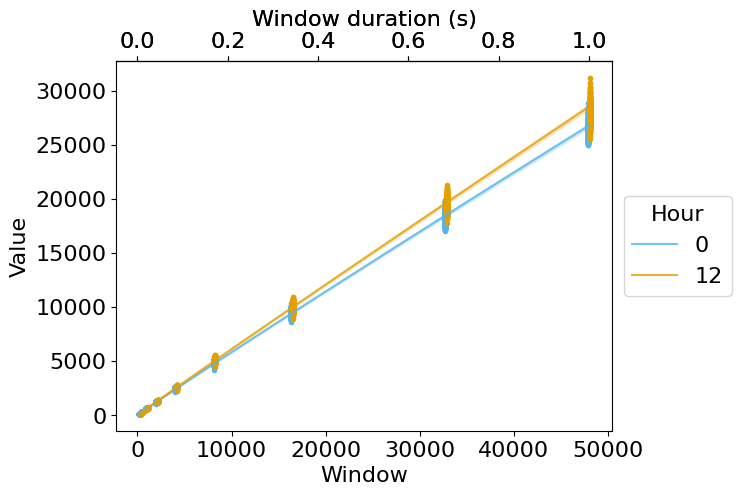

In [40]:
vicky_filtered_shrimp_ACI_fig


### Big Vicky - broadband ADI


In [41]:
vicky_extracted_broadband_ADI_fig, vicky_extracted_broadband_ADI_ratio_summary = experiment(vicky_df,
          broadband_ADI_group,
          vicky_toolbox,
          r_link,
          marine=True,
          factors=['Hour', 'Site'],
          cross_effect='Hour')


 Family: gamma 
  Links: mu = log; shape = identity 
Formula: Value ~ (Hour * Window) + (1 | Site) 
   Data: data (Number of observations: 4977) 
  Draws: 5 chains, each with iter = 10000; warmup = 5000; thin = 1;
         total post-warmup draws = 25000

Multilevel Hyperparameters:
~Site (Number of levels: 25) 
              Estimate Est.Error l-95% CI u-95% CI Rhat Bulk_ESS Tail_ESS
sd(Intercept)     0.02      0.00     0.02     0.03 1.00     3028     4963

Regression Coefficients:
              Estimate Est.Error l-95% CI u-95% CI Rhat Bulk_ESS Tail_ESS
Intercept         1.55      0.01     1.53     1.56 1.00     4219     8839
Hour12            0.10      0.01     0.09     0.12 1.00    14332    15729
Window            0.01      0.00     0.00     0.01 1.00    17842    18925
Hour12:Window    -0.01      0.00    -0.01    -0.01 1.00    14473    16602

Further Distributional Parameters:
      Estimate Est.Error l-95% CI u-95% CI Rhat Bulk_ESS Tail_ESS
shape   348.74      6.95   335.34   362.

In [42]:
print(vicky_extracted_broadband_ADI_ratio_summary)


# A tibble: 1 × 2
   mean      sd
  <dbl>   <dbl>
1  1.07 0.00493



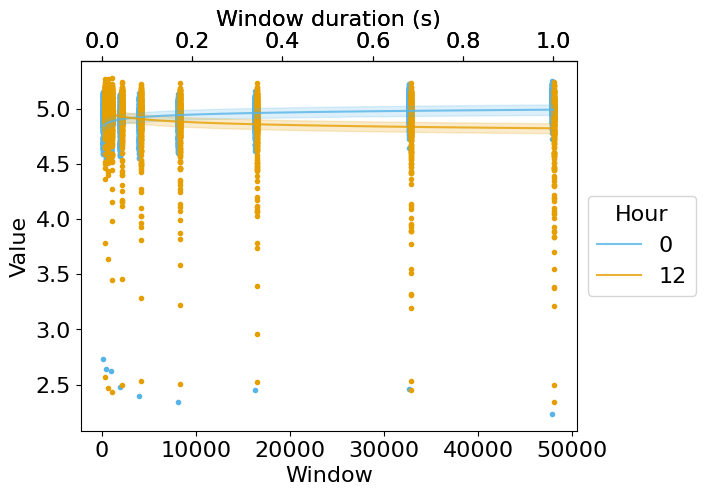

In [43]:
vicky_extracted_broadband_ADI_fig


### Big Vicky - extracted fish ADI


In [44]:
vicky_extracted_fish_ADI_fig, vicky_extracted_fish_ADI_ratio_summary = experiment(vicky_df,
          fish_extracted_ADI_group,
          vicky_toolbox,
          r_link,
          marine=True,
          factors=['Hour', 'Site'],
          cross_effect='Hour')


 Family: gamma 
  Links: mu = log; shape = identity 
Formula: Value ~ (Hour * Window) + (1 | Site) 
   Data: data (Number of observations: 4977) 
  Draws: 5 chains, each with iter = 10000; warmup = 5000; thin = 1;
         total post-warmup draws = 25000

Multilevel Hyperparameters:
~Site (Number of levels: 25) 
              Estimate Est.Error l-95% CI u-95% CI Rhat Bulk_ESS Tail_ESS
sd(Intercept)     0.03      0.01     0.02     0.04 1.00     4003     5336

Regression Coefficients:
              Estimate Est.Error l-95% CI u-95% CI Rhat Bulk_ESS Tail_ESS
Intercept        -0.07      0.01    -0.10    -0.05 1.00     7519    11974
Hour12            0.02      0.01    -0.01     0.04 1.00    14807    15095
Window            0.05      0.00     0.05     0.06 1.00    17878    20073
Hour12:Window    -0.01      0.00    -0.01    -0.00 1.00    14743    16081

Further Distributional Parameters:
      Estimate Est.Error l-95% CI u-95% CI Rhat Bulk_ESS Tail_ESS
shape   103.49      2.09    99.41   107.

In [45]:
print(vicky_extracted_fish_ADI_ratio_summary)


# A tibble: 1 × 2
   mean      sd
  <dbl>   <dbl>
1  1.04 0.00897



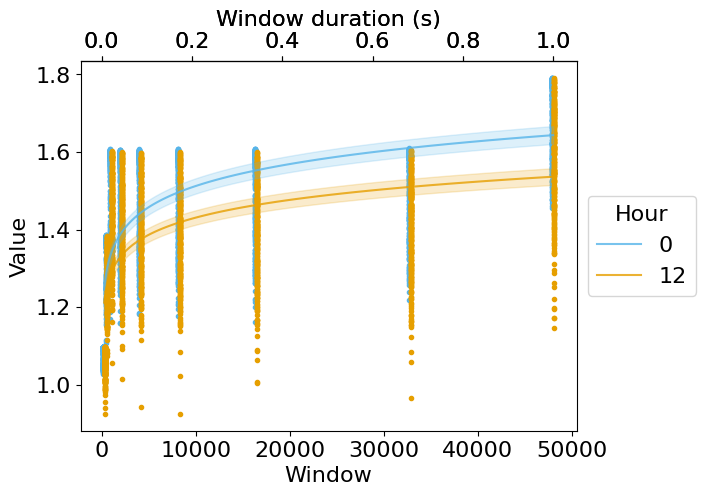

In [46]:
vicky_extracted_fish_ADI_fig


### Big Vicky - extracted shrimp ADI


In [47]:
vicky_extracted_shrimp_ADI_fig, vicky_extracted_shrimp_ADI_ratio_summary = experiment(vicky_df,
          shrimp_extracted_ADI_group,
          vicky_toolbox,
          r_link,
          marine=True,
          factors=['Hour', 'Site'],
          cross_effect='Hour')


 Family: gamma 
  Links: mu = log; shape = identity 
Formula: Value ~ (Hour * Window) + (1 | Site) 
   Data: data (Number of observations: 4977) 
  Draws: 5 chains, each with iter = 10000; warmup = 5000; thin = 1;
         total post-warmup draws = 25000

Multilevel Hyperparameters:
~Site (Number of levels: 25) 
              Estimate Est.Error l-95% CI u-95% CI Rhat Bulk_ESS Tail_ESS
sd(Intercept)     0.00      0.00     0.00     0.00 1.00     5693     6919

Regression Coefficients:
              Estimate Est.Error l-95% CI u-95% CI Rhat Bulk_ESS Tail_ESS
Intercept         1.18      0.00     1.18     1.18 1.00    18591    19386
Hour12            0.01      0.00     0.00     0.01 1.00    35141    17628
Window            0.00      0.00     0.00     0.00 1.00    28803    20494
Hour12:Window    -0.00      0.00    -0.00    -0.00 1.00    34588    18390

Further Distributional Parameters:
      Estimate Est.Error l-95% CI u-95% CI Rhat Bulk_ESS Tail_ESS
shape  5061.25    101.58  4863.31  5262.

In [48]:
print(vicky_extracted_shrimp_ADI_ratio_summary)


# A tibble: 1 × 2
   mean      sd
  <dbl>   <dbl>
1  1.00 0.00122



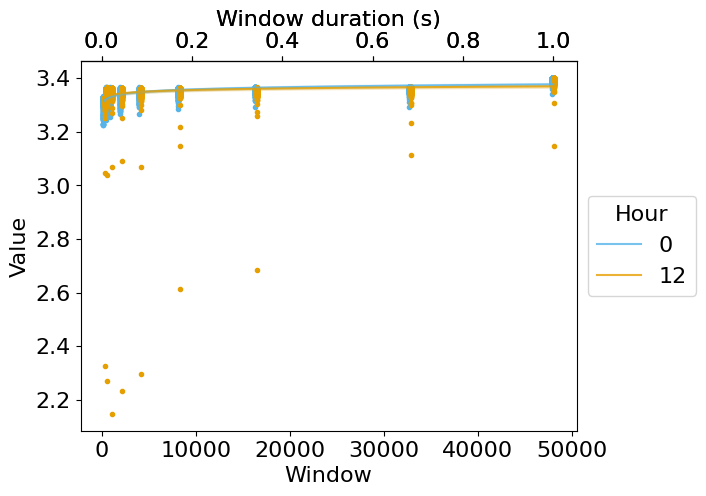

In [49]:
vicky_extracted_shrimp_ADI_fig


### Big Vicky - filtered fish ADI


In [50]:
vicky_filtered_fish_ADI_fig, vicky_filtered_fish_ADI_ratio_summary = experiment(vicky_df,
          fish_filtered_ADI_group,
          vicky_toolbox,
          r_link,
          marine=True,
          factors=['Hour', 'Site'],
          cross_effect='Hour')


 Family: gamma 
  Links: mu = log; shape = identity 
Formula: Value ~ (Hour * Window) + (1 | Site) 
   Data: data (Number of observations: 4977) 
  Draws: 5 chains, each with iter = 10000; warmup = 5000; thin = 1;
         total post-warmup draws = 25000

Multilevel Hyperparameters:
~Site (Number of levels: 25) 
              Estimate Est.Error l-95% CI u-95% CI Rhat Bulk_ESS Tail_ESS
sd(Intercept)     0.03      0.00     0.02     0.04 1.00     2314     3773

Regression Coefficients:
              Estimate Est.Error l-95% CI u-95% CI Rhat Bulk_ESS Tail_ESS
Intercept         0.75      0.01     0.73     0.77 1.00     2247     3908
Hour12           -0.07      0.01    -0.09    -0.06 1.00    11857    13631
Window           -0.01      0.00    -0.01    -0.01 1.00    16273    18278
Hour12:Window    -0.00      0.00    -0.01    -0.00 1.00    11923    14067

Further Distributional Parameters:
      Estimate Est.Error l-95% CI u-95% CI Rhat Bulk_ESS Tail_ESS
shape   382.98      7.71   368.03   398.

In [51]:
print(vicky_filtered_fish_ADI_ratio_summary)


# A tibble: 1 × 2
   mean      sd
  <dbl>   <dbl>
1  1.02 0.00437



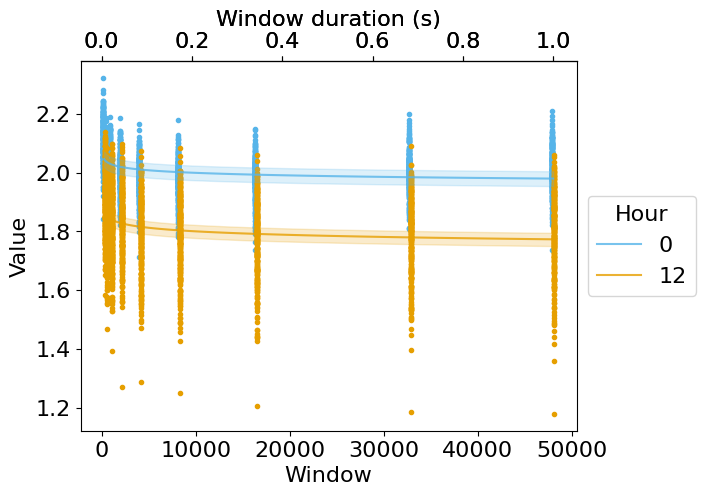

In [52]:
vicky_filtered_fish_ADI_fig


### Big Vicky - filtered shrimp ADI


In [53]:
vicky_filtered_shrimp_ADI_fig, vicky_filtered_shrimp_ADI_ratio_summary = experiment(vicky_df,
          shrimp_filtered_ADI_group,
          vicky_toolbox,
          r_link,
          marine=True,
          factors=['Hour', 'Site'],
          cross_effect='Hour')


 Family: gamma 
  Links: mu = log; shape = identity 
Formula: Value ~ (Hour * Window) + (1 | Site) 
   Data: data (Number of observations: 4977) 
  Draws: 5 chains, each with iter = 10000; warmup = 5000; thin = 1;
         total post-warmup draws = 25000

Multilevel Hyperparameters:
~Site (Number of levels: 25) 
              Estimate Est.Error l-95% CI u-95% CI Rhat Bulk_ESS Tail_ESS
sd(Intercept)     0.01      0.00     0.00     0.01 1.00     2565     6117

Regression Coefficients:
              Estimate Est.Error l-95% CI u-95% CI Rhat Bulk_ESS Tail_ESS
Intercept         1.24      0.00     1.24     1.24 1.00     3836     8268
Hour12            0.03      0.00     0.02     0.03 1.00    20798    17559
Window            0.00      0.00     0.00     0.00 1.00    23141    19120
Hour12:Window    -0.00      0.00    -0.00    -0.00 1.00    20828    18501

Further Distributional Parameters:
      Estimate Est.Error l-95% CI u-95% CI Rhat Bulk_ESS Tail_ESS
shape  4217.91     85.24  4053.11  4386.

In [54]:
print(vicky_filtered_shrimp_ADI_ratio_summary)


# A tibble: 1 × 2
   mean      sd
  <dbl>   <dbl>
1  1.02 0.00132



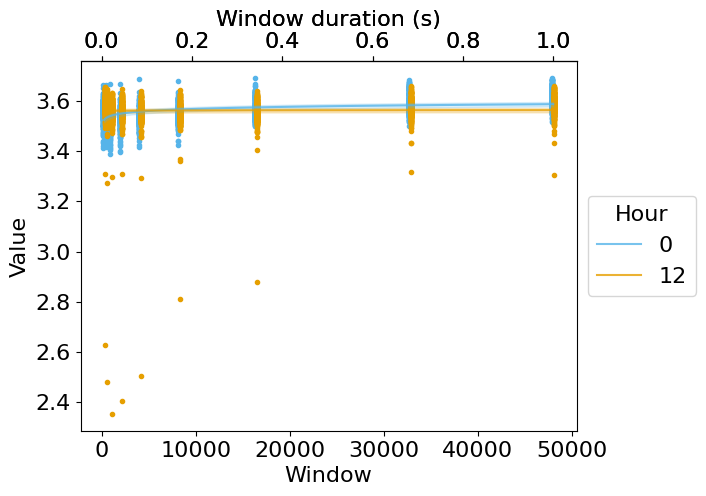

In [55]:
vicky_filtered_shrimp_ADI_fig


### Big Vicky - broadband AEI


In [56]:
vicky_extracted_broadband_AEI_fig, vicky_extracted_broadband_AEI_ratio_summary = experiment(vicky_df,
          broadband_AEI_group,
          vicky_toolbox,
          r_link,
          marine=True,
          factors=['Hour', 'Site'],
          cross_effect='Hour')


 Family: beta 
  Links: mu = logit; phi = identity 
Formula: Value ~ (Hour * Window) + (1 | Site) 
   Data: data (Number of observations: 4977) 
  Draws: 5 chains, each with iter = 10000; warmup = 5000; thin = 1;
         total post-warmup draws = 25000

Multilevel Hyperparameters:
~Site (Number of levels: 25) 
              Estimate Est.Error l-95% CI u-95% CI Rhat Bulk_ESS Tail_ESS
sd(Intercept)     1.12      0.08     1.01     1.25 2.26        6       24

Regression Coefficients:
              Estimate Est.Error l-95% CI u-95% CI Rhat Bulk_ESS Tail_ESS
Intercept         0.26      0.02     0.23     0.30 2.08        7       28
Hour12           -0.18      0.01    -0.20    -0.16 1.01      636      985
Window           -0.00      0.00    -0.00    -0.00 1.00     3439    10139
Hour12:Window     0.00      0.00     0.00     0.00 1.00     1654     5325

Further Distributional Parameters:
    Estimate Est.Error l-95% CI u-95% CI Rhat Bulk_ESS Tail_ESS
phi    55.90      1.53    52.01    58.39 1.

In [57]:
print(vicky_extracted_broadband_AEI_ratio_summary)


# A tibble: 1 × 2
   mean     sd
  <dbl>  <dbl>
1  1.32 0.0148



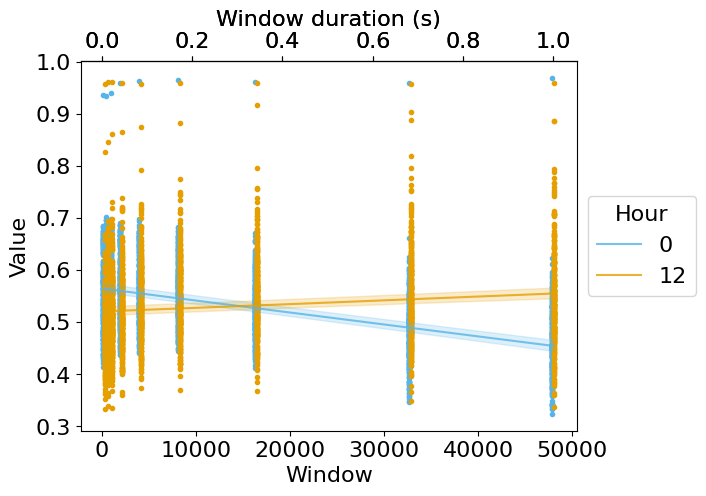

In [58]:
vicky_extracted_broadband_AEI_fig


### Big Vicky - extracted fish AEI


In [59]:
vicky_extracted_fish_AEI_fig, vicky_extracted_fish_AEI_ratio_summary = experiment(vicky_df,
          fish_extracted_AEI_group,
          vicky_toolbox,
          r_link,
          marine=True,
          factors=['Hour', 'Site'],
          cross_effect='Hour')


 Family: beta 
  Links: mu = logit; phi = identity 
Formula: Value ~ (Hour * Window) + (1 | Site) 
   Data: data (Number of observations: 4977) 
  Draws: 5 chains, each with iter = 10000; warmup = 5000; thin = 1;
         total post-warmup draws = 25000

Multilevel Hyperparameters:
~Site (Number of levels: 25) 
              Estimate Est.Error l-95% CI u-95% CI Rhat Bulk_ESS Tail_ESS
sd(Intercept)     1.02      0.13     0.74     1.27 1.63        8       32

Regression Coefficients:
              Estimate Est.Error l-95% CI u-95% CI Rhat Bulk_ESS Tail_ESS
Intercept        -1.44      0.05    -1.57    -1.36 1.96        7       11
Hour12            0.40      0.02     0.36     0.45 1.01      521     1410
Window            0.00      0.00     0.00     0.00 1.00     2960     8469
Hour12:Window     0.00      0.00     0.00     0.00 1.00     1703     5651

Further Distributional Parameters:
    Estimate Est.Error l-95% CI u-95% CI Rhat Bulk_ESS Tail_ESS
phi    11.62      0.23    11.18    12.07 1.

In [60]:
print(vicky_extracted_fish_AEI_ratio_summary)


# A tibble: 1 × 2
   mean     sd
  <dbl>  <dbl>
1  1.09 0.0413



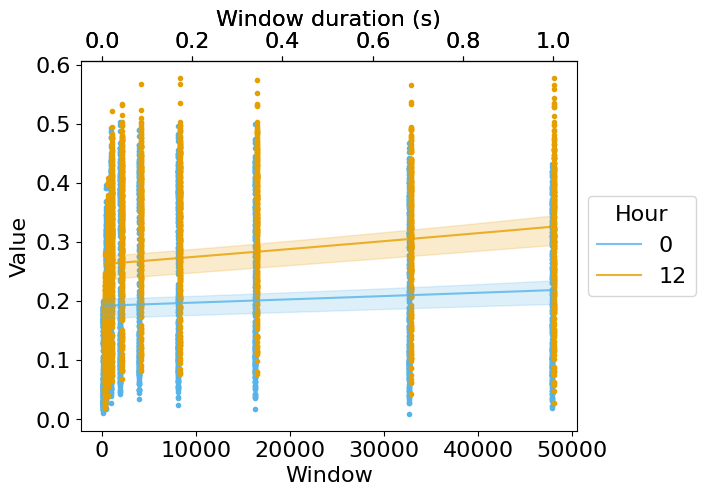

In [61]:
vicky_extracted_fish_AEI_fig


### Big Vicky - extracted shrimp AEI


In [62]:
vicky_extracted_shrimp_AEI_fig, vicky_extracted_shrimp_AEI_ratio_summary = experiment(vicky_df,
          shrimp_extracted_AEI_group,
          vicky_toolbox,
          r_link,
          marine=True,
          factors=['Hour', 'Site'],
          cross_effect='Hour')


 Family: beta 
  Links: mu = logit; phi = identity 
Formula: Value ~ (Hour * Window) + (1 | Site) 
   Data: data (Number of observations: 4977) 
  Draws: 5 chains, each with iter = 10000; warmup = 5000; thin = 1;
         total post-warmup draws = 25000

Multilevel Hyperparameters:
~Site (Number of levels: 25) 
              Estimate Est.Error l-95% CI u-95% CI Rhat Bulk_ESS Tail_ESS
sd(Intercept)     1.09      0.24     0.52     1.45 1.76        8       11

Regression Coefficients:
              Estimate Est.Error l-95% CI u-95% CI Rhat Bulk_ESS Tail_ESS
Intercept        -2.02      0.03    -2.07    -1.96 2.03        7       21
Hour12           -0.17      0.01    -0.20    -0.15 1.02      450      452
Window           -0.00      0.00    -0.00    -0.00 1.01     1950     6605
Hour12:Window     0.00      0.00     0.00     0.00 1.01     1347     3593

Further Distributional Parameters:
    Estimate Est.Error l-95% CI u-95% CI Rhat Bulk_ESS Tail_ESS
phi    75.46      1.52    72.53    78.48 1.

In [63]:
print(vicky_extracted_shrimp_AEI_ratio_summary)


# A tibble: 1 × 2
   mean     sd
  <dbl>  <dbl>
1  1.93 0.0695



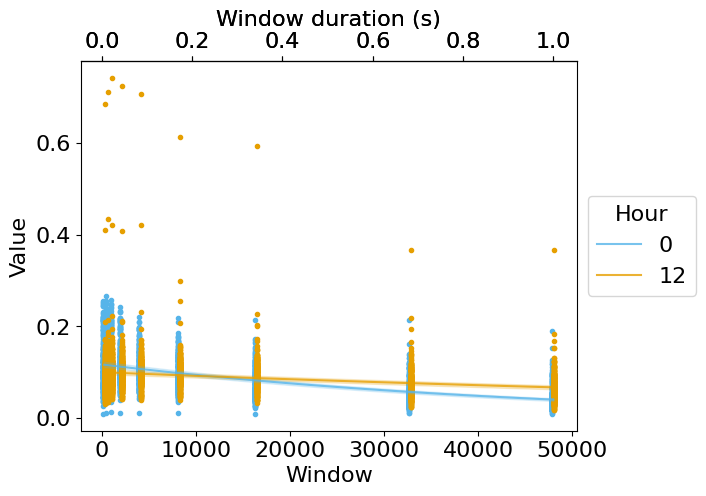

In [64]:
vicky_extracted_shrimp_AEI_fig


### Big Vicky - filtered fish AEI


In [65]:
vicky_filtered_fish_AEI_fig, vicky_filtered_fish_AEI_ratio_summary = experiment(vicky_df,
          fish_filtered_AEI_group,
          vicky_toolbox,
          r_link,
          marine=True,
          factors=['Hour', 'Site'],
          cross_effect='Hour')


 Family: beta 
  Links: mu = logit; phi = identity 
Formula: Value ~ (Hour * Window) + (1 | Site) 
   Data: data (Number of observations: 4977) 
  Draws: 5 chains, each with iter = 10000; warmup = 5000; thin = 1;
         total post-warmup draws = 25000

Multilevel Hyperparameters:
~Site (Number of levels: 25) 
              Estimate Est.Error l-95% CI u-95% CI Rhat Bulk_ESS Tail_ESS
sd(Intercept)     0.99      0.01     0.97     1.01 3.10        6       16

Regression Coefficients:
              Estimate Est.Error l-95% CI u-95% CI Rhat Bulk_ESS Tail_ESS
Intercept         3.63      0.00     3.63     3.64 1.67        8       20
Hour12            0.20      0.00     0.20     0.21 1.03      304      765
Window            0.00      0.00    -0.00     0.00 1.00     2053     8230
Hour12:Window     0.00      0.00     0.00     0.00 1.01     1039     3909

Further Distributional Parameters:
    Estimate Est.Error l-95% CI u-95% CI Rhat Bulk_ESS Tail_ESS
phi  3556.68    106.61  3316.57  3741.40 1.

In [66]:
print(vicky_filtered_fish_AEI_ratio_summary)


# A tibble: 1 × 2
   mean       sd
  <dbl>    <dbl>
1  1.00 0.000220



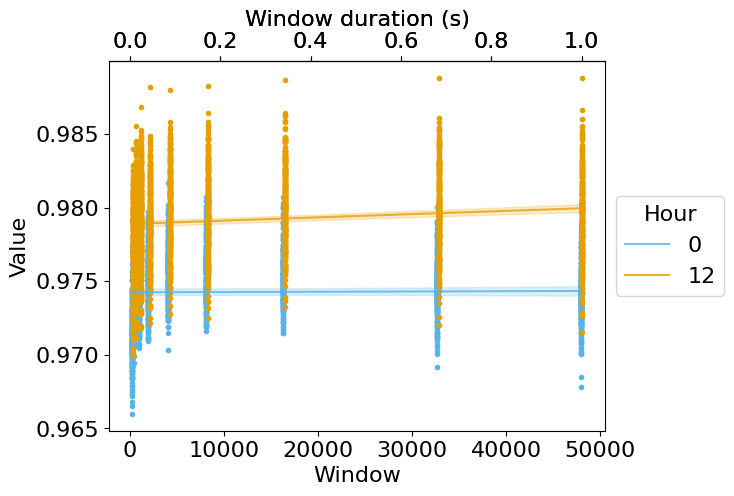

In [67]:
vicky_filtered_fish_AEI_fig


### Big Vicky - filtered shrimp AEI


In [68]:
vicky_filtered_shrimp_AEI_fig, vicky_filtered_shrimp_AEI_ratio_summary = experiment(vicky_df,
          shrimp_filtered_AEI_group,
          vicky_toolbox,
          r_link,
          marine=True,
          factors=['Hour', 'Site'],
          cross_effect='Hour')


 Family: beta 
  Links: mu = logit; phi = identity 
Formula: Value ~ (Hour * Window) + (1 | Site) 
   Data: data (Number of observations: 4977) 
  Draws: 5 chains, each with iter = 10000; warmup = 5000; thin = 1;
         total post-warmup draws = 25000

Multilevel Hyperparameters:
~Site (Number of levels: 25) 
              Estimate Est.Error l-95% CI u-95% CI Rhat Bulk_ESS Tail_ESS
sd(Intercept)     1.00      0.01     0.98     1.01 3.50        5       12

Regression Coefficients:
              Estimate Est.Error l-95% CI u-95% CI Rhat Bulk_ESS Tail_ESS
Intercept         1.98      0.00     1.97     1.98 1.59        8       25
Hour12           -0.03      0.00    -0.04    -0.02 1.15       22       54
Window           -0.00      0.00    -0.00    -0.00 1.04       81      212
Hour12:Window     0.00      0.00     0.00     0.00 1.07       43       92

Further Distributional Parameters:
    Estimate Est.Error l-95% CI u-95% CI Rhat Bulk_ESS Tail_ESS
phi  2075.61     85.84  1877.37  2240.43 2.

In [69]:
print(vicky_filtered_shrimp_AEI_ratio_summary)


# A tibble: 1 × 2
   mean       sd
  <dbl>    <dbl>
1  1.01 0.000836



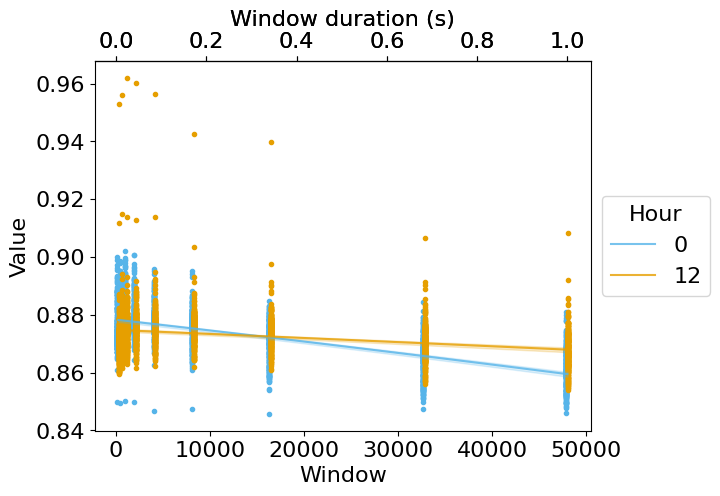

In [70]:
vicky_filtered_shrimp_AEI_fig


### Big Vicky - broadband BIO


In [71]:
vicky_extracted_broadband_BIO_fig, vicky_extracted_broadband_BIO_ratio_summary = experiment(vicky_df,
          broadband_BIO_group,
          vicky_toolbox,
          r_link,
          marine=True,
          factors=['Hour', 'Site'],
          cross_effect='Hour')


 Family: gamma 
  Links: mu = log; shape = identity 
Formula: Value ~ (Hour * Window) + (1 | Site) 
   Data: data (Number of observations: 4977) 
  Draws: 5 chains, each with iter = 10000; warmup = 5000; thin = 1;
         total post-warmup draws = 25000

Multilevel Hyperparameters:
~Site (Number of levels: 25) 
              Estimate Est.Error l-95% CI u-95% CI Rhat Bulk_ESS Tail_ESS
sd(Intercept)     0.15      0.02     0.11     0.20 1.00     1261     2580

Regression Coefficients:
              Estimate Est.Error l-95% CI u-95% CI Rhat Bulk_ESS Tail_ESS
Intercept        -8.37      0.03    -8.44    -8.31 1.00     1556     2445
Hour12            0.01      0.01    -0.01     0.04 1.00     5401     6704
Window            2.03      0.00     2.03     2.03 1.00     6673     9150
Hour12:Window    -0.02      0.00    -0.02    -0.02 1.00     5438     6636

Further Distributional Parameters:
      Estimate Est.Error l-95% CI u-95% CI Rhat Bulk_ESS Tail_ESS
shape   131.49      2.67   126.30   136.

In [72]:
print(vicky_extracted_broadband_BIO_ratio_summary)


# A tibble: 1 × 2
   mean      sd
  <dbl>   <dbl>
1  1.10 0.00836



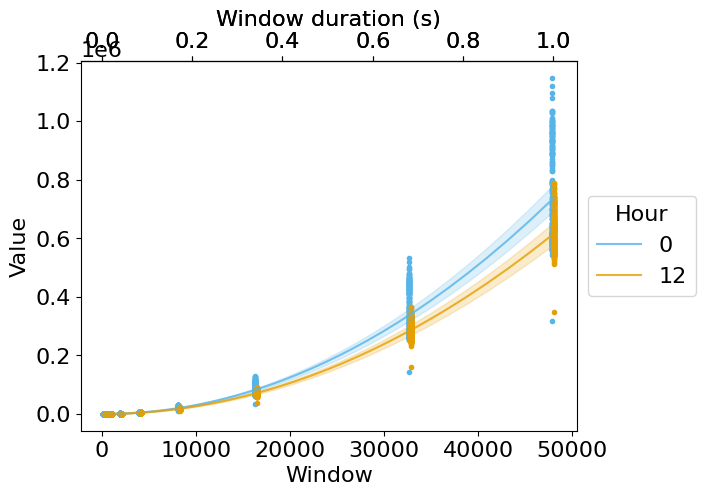

In [73]:
vicky_extracted_broadband_BIO_fig


### Big Vicky - extracted fish BIO


In [74]:
vicky_extracted_fish_BIO_fig, vicky_extracted_fish_BIO_ratio_summary = experiment(vicky_df,
          fish_extracted_BIO_group,
          vicky_toolbox,
          r_link,
          marine=True,
          factors=['Hour', 'Site'],
          cross_effect='Hour')


 Family: gamma 
  Links: mu = log; shape = identity 
Formula: Value ~ (Hour * Window) + (1 | Site) 
   Data: data (Number of observations: 4977) 
  Draws: 5 chains, each with iter = 10000; warmup = 5000; thin = 1;
         total post-warmup draws = 25000

Multilevel Hyperparameters:
~Site (Number of levels: 25) 
              Estimate Est.Error l-95% CI u-95% CI Rhat Bulk_ESS Tail_ESS
sd(Intercept)     0.31      0.05     0.23     0.43 1.00     2136     3876

Regression Coefficients:
              Estimate Est.Error l-95% CI u-95% CI Rhat Bulk_ESS Tail_ESS
Intercept       -14.58      0.08   -14.74   -14.43 1.00     2477     4682
Hour12            0.26      0.06     0.14     0.38 1.00     6290     9508
Window            2.18      0.01     2.17     2.19 1.00     7279    11391
Hour12:Window    -0.05      0.01    -0.06    -0.03 1.00     6247     9574

Further Distributional Parameters:
      Estimate Est.Error l-95% CI u-95% CI Rhat Bulk_ESS Tail_ESS
shape     5.44      0.11     5.23     5.

In [75]:
print(vicky_extracted_fish_BIO_ratio_summary)


# A tibble: 1 × 2
   mean     sd
  <dbl>  <dbl>
1  1.28 0.0481



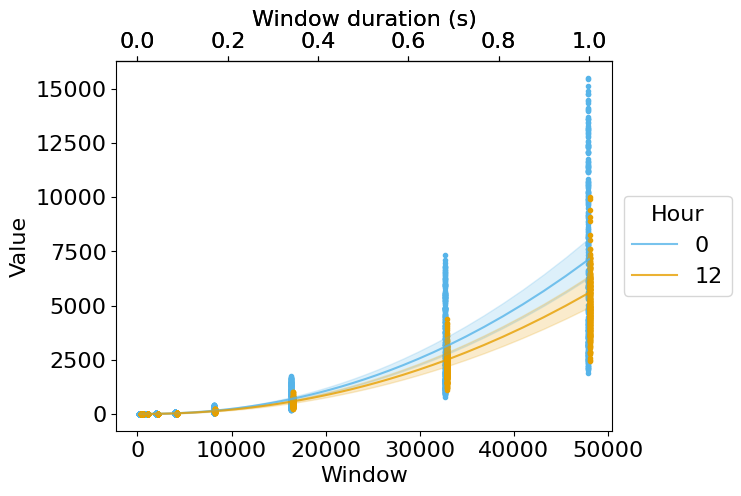

In [76]:
vicky_extracted_fish_BIO_fig


### Big Vicky - extracted shrimp BIO


In [77]:
vicky_extracted_shrimp_BIO_fig, vicky_extracted_shrimp_BIO_ratio_summary = experiment(vicky_df,
          shrimp_extracted_BIO_group,
          vicky_toolbox,
          r_link,
          marine=True,
          factors=['Hour', 'Site'],
          cross_effect='Hour')


 Family: gamma 
  Links: mu = log; shape = identity 
Formula: Value ~ (Hour * Window) + (1 | Site) 
   Data: data (Number of observations: 4977) 
  Draws: 5 chains, each with iter = 10000; warmup = 5000; thin = 1;
         total post-warmup draws = 25000

Multilevel Hyperparameters:
~Site (Number of levels: 25) 
              Estimate Est.Error l-95% CI u-95% CI Rhat Bulk_ESS Tail_ESS
sd(Intercept)     0.23      0.04     0.17     0.31 1.00     2038     4243

Regression Coefficients:
              Estimate Est.Error l-95% CI u-95% CI Rhat Bulk_ESS Tail_ESS
Intercept       -13.00      0.05   -13.11   -12.90 1.00     1630     1883
Hour12            0.06      0.03     0.01     0.11 1.00     5457     7906
Window            2.09      0.00     2.09     2.09 1.00     6320    10143
Hour12:Window     0.01      0.00    -0.00     0.01 1.00     5409     7991

Further Distributional Parameters:
      Estimate Est.Error l-95% CI u-95% CI Rhat Bulk_ESS Tail_ESS
shape    28.43      0.57    27.35    29.

In [78]:
print(vicky_extracted_shrimp_BIO_ratio_summary)


# A tibble: 1 × 2
   mean     sd
  <dbl>  <dbl>
1  1.03 0.0161



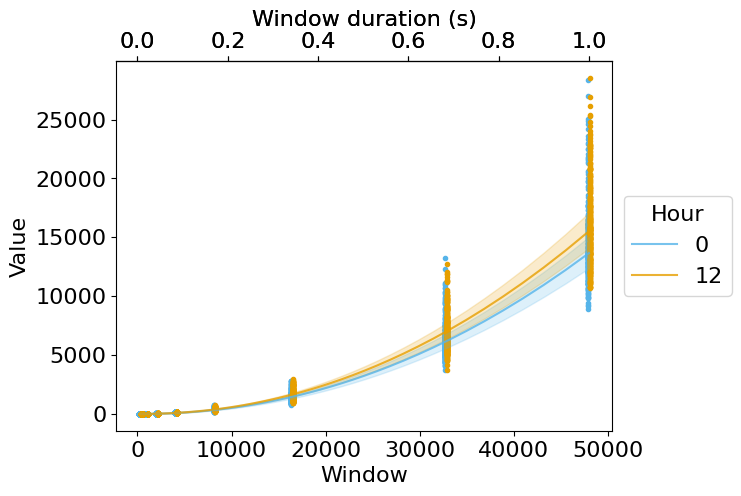

In [79]:
vicky_extracted_shrimp_BIO_fig


### Big Vicky - filtered fish BIO


In [80]:
vicky_filtered_fish_BIO_fig, vicky_filtered_fish_BIO_ratio_summary = experiment(vicky_df,
          fish_filtered_BIO_group,
          vicky_toolbox,
          r_link,
          marine=True,
          factors=['Hour', 'Site'],
          cross_effect='Hour')


 Family: gamma 
  Links: mu = log; shape = identity 
Formula: Value ~ (Hour * Window) + (1 | Site) 
   Data: data (Number of observations: 4977) 
  Draws: 5 chains, each with iter = 10000; warmup = 5000; thin = 1;
         total post-warmup draws = 25000

Multilevel Hyperparameters:
~Site (Number of levels: 25) 
              Estimate Est.Error l-95% CI u-95% CI Rhat Bulk_ESS Tail_ESS
sd(Intercept)     0.02      0.00     0.02     0.03 1.01     1710     2971

Regression Coefficients:
              Estimate Est.Error l-95% CI u-95% CI Rhat Bulk_ESS Tail_ESS
Intercept        -9.13      0.01    -9.14    -9.12 1.00     1978     3485
Hour12            0.01      0.00     0.01     0.02 1.00    10656    13688
Window            2.07      0.00     2.06     2.07 1.00    15094    16576
Hour12:Window    -0.01      0.00    -0.01    -0.01 1.00    10840    13920

Further Distributional Parameters:
      Estimate Est.Error l-95% CI u-95% CI Rhat Bulk_ESS Tail_ESS
shape  1410.58     28.54  1355.81  1467.

In [81]:
print(vicky_filtered_fish_BIO_ratio_summary)


# A tibble: 1 × 2
   mean      sd
  <dbl>   <dbl>
1  1.06 0.00240



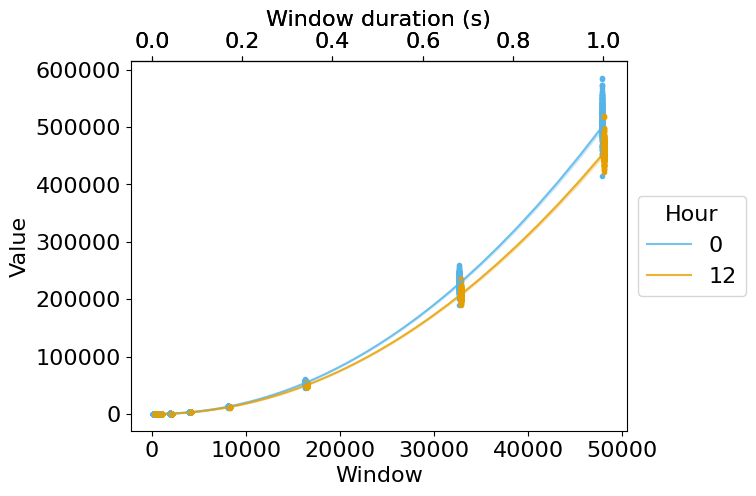

In [82]:
vicky_filtered_fish_BIO_fig


### Big Vicky - filtered shrimp BIO


In [83]:
vicky_filtered_shrimp_BIO_fig, vicky_filtered_shrimp_BIO_ratio_summary = experiment(vicky_df,
          shrimp_filtered_BIO_group,
          vicky_toolbox,
          r_link,
          marine=True,
          factors=['Hour', 'Site'],
          cross_effect='Hour')


 Family: gamma 
  Links: mu = log; shape = identity 
Formula: Value ~ (Hour * Window) + (1 | Site) 
   Data: data (Number of observations: 4977) 
  Draws: 5 chains, each with iter = 10000; warmup = 5000; thin = 1;
         total post-warmup draws = 25000

Multilevel Hyperparameters:
~Site (Number of levels: 25) 
              Estimate Est.Error l-95% CI u-95% CI Rhat Bulk_ESS Tail_ESS
sd(Intercept)     0.02      0.00     0.01     0.02 1.00     2265     4558

Regression Coefficients:
              Estimate Est.Error l-95% CI u-95% CI Rhat Bulk_ESS Tail_ESS
Intercept        -8.67      0.00    -8.68    -8.67 1.00     2549     4379
Hour12           -0.01      0.00    -0.02     0.00 1.00    12347    14748
Window            2.10      0.00     2.10     2.10 1.00    16397    18971
Hour12:Window     0.00      0.00     0.00     0.00 1.00    12547    15747

Further Distributional Parameters:
      Estimate Est.Error l-95% CI u-95% CI Rhat Bulk_ESS Tail_ESS
shape  1136.65     22.93  1091.97  1182.

In [84]:
print(vicky_filtered_shrimp_BIO_ratio_summary)


# A tibble: 1 × 2
   mean      sd
  <dbl>   <dbl>
1  1.02 0.00257



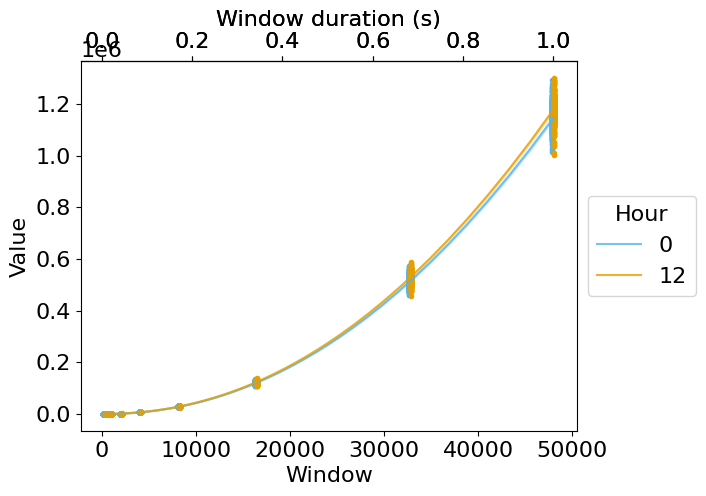

In [85]:
vicky_filtered_shrimp_BIO_fig
